<a href="https://colab.research.google.com/github/DoyulPark/pdm08/blob/master/py-tensorflow/tf2_6_mnist_CNN_best_start_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of mnist dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    * FCN : 1차원 완전연결신경망

***
- ## Traget: **Find the best model**
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
tf.random.set_seed(0)

2.3.0


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import mnist

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

11493376/11490434 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display numbers
- one random number
- 10 representative numbers

371


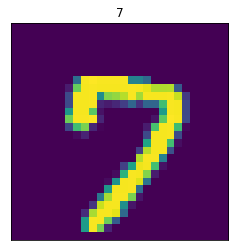

In [6]:
# Code here!
# display one random image from the training set:
class_names = ["0","1","2","3","4","5","6","7","8","9"]

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

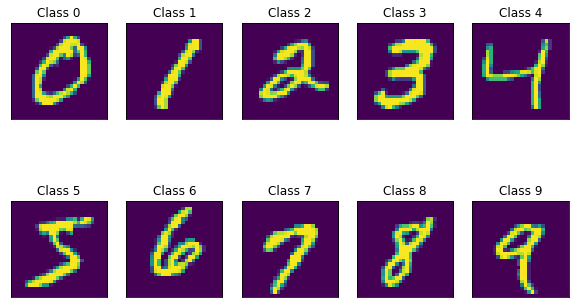

In [8]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **CNN2 + FCN2**

In [10]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [12]:
c2f2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [13]:
# 1st Conv2D parameters
9*32+32

320

In [14]:
# 2nd Conv2D parameters
32*64*3*3 + 64

18496

In [16]:
cp_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=20)    # patience=10, 20, 50 (50은시간이 오래 걸림)

In [17]:
# Train CNN model
# Find and save the best model.
hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1546 - accuracy: 0.9528 - val_loss: 0.0459 - val_accuracy: 0.9844
Epoch 2/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 3/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0390 - accuracy: 0.9877 - val_loss: 0.0288 - val_accuracy: 0.9909
Epoch 4/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0302 - accuracy: 0.9902 - val_loss: 0.0329 - val_accuracy: 0.9888
Epoch 5/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0285 - val_accuracy: 0.9907
Epoch 6/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0181 - accuracy: 0.9938 - val_loss: 0.0318 - val_accuracy: 0.9901
Epoch 7/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.0260 - val_ac

In [20]:
c2f2.evaluate(X_test, y_test, batch_size =32)

313/313 [==============================] - 1s 2ms/step - loss: 0.0515 - accuracy: 0.9932


[0.05147525668144226, 0.9932000041007996]

## Graph of loss and accuracy
- model: C2F2

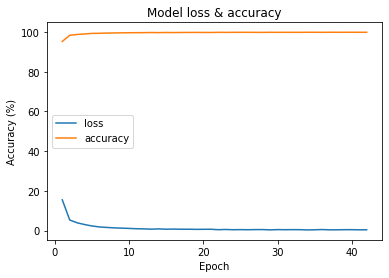

In [23]:
# Plot loass and accuracy
# Plot training & validation accuracy values

epochs = 42 #위에 Epoch가 42에서 끝남
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [24]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

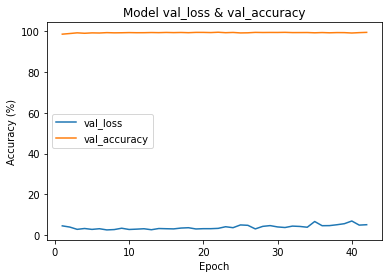

In [25]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

In [26]:
np.argmax(np.array(vacc_list)) #가장 높은 부분의 epoch->22번째의 epoch

21

In [29]:
vacc_list[np.argmax(np.array(vacc_list))]

99.37999844551086

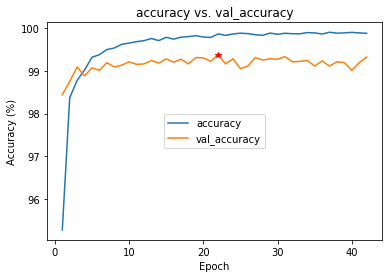

In [31]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center') #가장높은부분을 빨간색으로 표시
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 

## 최적화된 모형 불러와서 이용

- callbacks.ModelCheckpoint를 이용해서 트레이닝 중 val_accuacy가 가장 높은 모형을 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

> mnist_c2f2_best_weights.022-0.9938.hdf5

In [32]:
# c2f2.save('cnn_best.hdf5')

In [33]:
from keras.models import load_model

model = load_model('mnist_c2f2_best_weights.022-0.9938.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 0.0336 - accuracy: 0.9938


[0.03358296677470207, 0.9937999844551086]

## [DIY] C2F3의 best model을 구하시오.

## **CNN2 + FCN3**

In [34]:
c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [35]:
c2f3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [36]:
# Your code here!!!

cp_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=50)    # patience=10, 20, 50 # 과제할 땐 50으로 설정

In [37]:
# Train CNN model
# Find and save the best model.
hist = c2f3.fit(X_train, y_train, epochs = 500 , batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2100 - accuracy: 0.9363 - val_loss: 0.0503 - val_accuracy: 0.9843
Epoch 2/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0711 - accuracy: 0.9800 - val_loss: 0.0375 - val_accuracy: 0.9883
Epoch 3/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0514 - accuracy: 0.9854 - val_loss: 0.0339 - val_accuracy: 0.9882
Epoch 4/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0421 - accuracy: 0.9876 - val_loss: 0.0327 - val_accuracy: 0.9890
Epoch 5/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0348 - accuracy: 0.9901 - val_loss: 0.0314 - val_accuracy: 0.9908
Epoch 6/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0277 - accuracy: 0.9921 - val_loss: 0.0290 - val_accuracy: 0.9905
Epoch 7/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 0.0308 - val_ac

In [38]:
c2f3.evaluate(X_test, y_test, batch_size =32)

313/313 [==============================] - 1s 2ms/step - loss: 0.0758 - accuracy: 0.9923


[0.07583366334438324, 0.9922999739646912]

## Graph of loss and accuracy
- model: C2F3

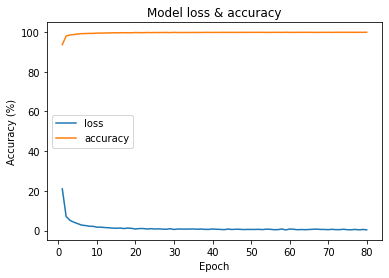

In [40]:
# Plot loass and accuracy
# Plot training & validation accuracy values

epochs = 80
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [41]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

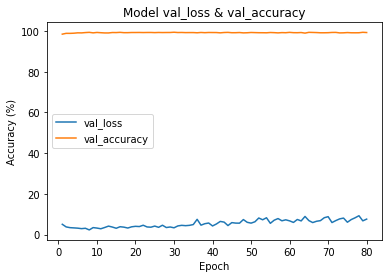

In [42]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

In [43]:
np.argmax(np.array(vacc_list))

29

In [44]:
vacc_list[np.argmax(np.array(vacc_list))]

99.37000274658203

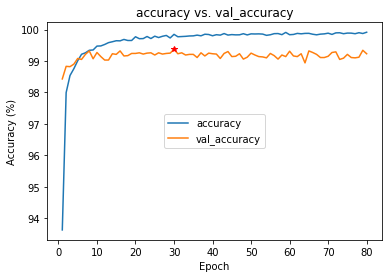

In [45]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy'], loc='center')
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 

## 최적화된 모형 불러와서 이용

- callbacks.ModelCheckpoint를 이용해서 트레이닝 중 val_accuacy가 가장 높은 모형을 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

> mnist_c2f3_best_weights.009-0.9944.hdf5

In [46]:
from keras.models import load_model

model = load_model('mnist_c2f3_best_weights.030-0.9937.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 0.0332 - accuracy: 0.9937


[0.03319570794701576, 0.9937000274658203]

***

## [DIY] fashion mnist model의 best model을 구하시오.

- github의 "py-tensorflow" 폴더에 tf2_7_fmnist_CNN_best.ipynb 파일을 올리시오. 
- github의 "py-tensorflow/st-code/model" 폴더에 best model(hdf5 파일)을 올리시오. 

> fashion mnist 데이터 로딩
```
from keras.datasets import fashion_mnist
(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()
```